# FORECASTING EXCHANGE RATES USING TIME SERIES ANALYSIS
### Objective:
#### Leverage ARIMA and Exponential Smoothing techniques to forecast future exchange rates based on historical data provided in the exchange_rate.csv dataset. 
### Dataset:
#### The dataset contains historical exchange rate with each column representing a different currency rate over time. The first column indicates the date, and second column represent exchange rates USD to Australian Dollar.
### Part 1: Data Preparation and Exploration
#### 1.	Data Loading: Load the exchange_rate.csv dataset and parse the date column appropriately.
#### 2.	Initial Exploration: Plot the time series for currency to understand their trends, seasonality, and any anomalies.
#### 3.	Data Preprocessing: Handle any missing values or anomalies identified during the exploration phase.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset and parse the date column
df = pd.read_csv("exchange_rate.csv")

# Display basic info and head of the dataset
df.info(), df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     7588 non-null   object 
 1   Ex_rate  7588 non-null   float64
dtypes: float64(1), object(1)
memory usage: 118.7+ KB


(None,
                date  Ex_rate
 0  01-01-1990 00:00   0.7855
 1  02-01-1990 00:00   0.7818
 2  03-01-1990 00:00   0.7867
 3  04-01-1990 00:00   0.7860
 4  05-01-1990 00:00   0.7849)

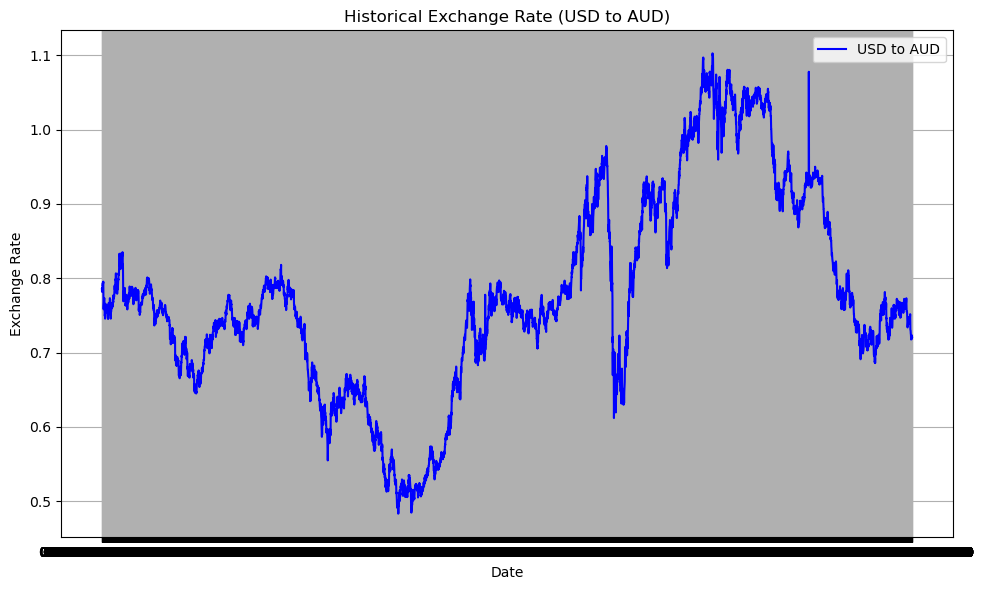

In [6]:
# Plot the time series data
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['Ex_rate'], label='USD to AUD', color='blue')
plt.title('Historical Exchange Rate (USD to AUD)')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [3]:
# Check for missing values
missing_values = df.isnull().sum()

# Basic statistical summary to spot anomalies
summary_stats = df['Ex_rate'].describe()

# Detect potential outliers using z-score method
from scipy.stats import zscore
df['zscore'] = zscore(df['Ex_rate'])
outliers = df[abs(df['zscore']) > 3]

missing_values, summary_stats, outliers.head()

(date       0
 Ex_rate    0
 dtype: int64,
 count    7588.000000
 mean        0.776974
 std         0.136620
 min         0.483297
 25%         0.701422
 50%         0.761377
 75%         0.873477
 max         1.102536
 Name: Ex_rate, dtype: float64,
 Empty DataFrame
 Columns: [date, Ex_rate, zscore]
 Index: [])

### Part 2: Model Building - ARIMA
#### 1.	Parameter Selection for ARIMA: Utilize ACF and PACF plots to estimate initial parameters (p, d, q) for the ARIMA model for one or more currency time series.
#### 2.	Model Fitting: Fit the ARIMA model with the selected parameters to the preprocessed time series.
#### 3.	Diagnostics: Analyze the residuals to ensure there are no patterns that might indicate model inadequacies.
#### 4.	Forecasting: Perform out-of-sample forecasting and visualize the predicted values against the actual values.


In [10]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['Ex_rate'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -1.6649941807381414
p-value: 0.4492327353597959


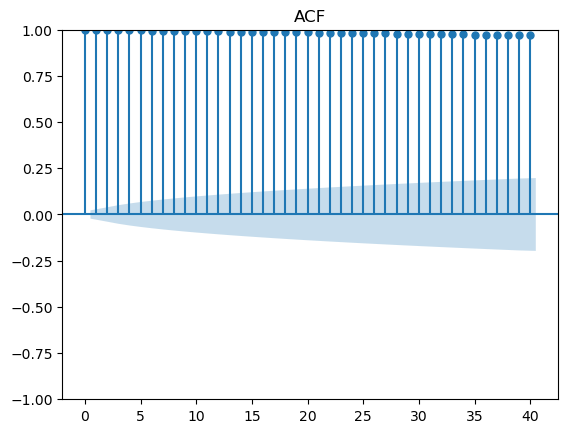

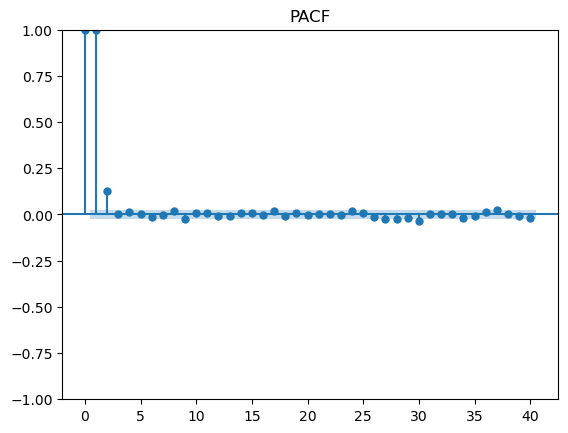

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df['Ex_rate'], lags=40)
plt.title('ACF')
plt.show()

plot_pacf(df['Ex_rate'], lags=40)
plt.title('PACF')
plt.show()

In [12]:
# First-order differencing
df_diff = df['Ex_rate'].diff().dropna()

# Re-test stationarity
result_diff = adfuller(df_diff)
print('Differenced ADF Statistic:', result_diff[0])
print('Differenced p-value:', result_diff[1])

Differenced ADF Statistic: -99.3934312011863
Differenced p-value: 0.0


In [15]:
from statsmodels.tsa.arima.model import ARIMA

# Example ARIMA(p=1, d=1, q=1) — adjust based on ACF/PACF
model = ARIMA(df['Ex_rate'], order=(1, 1, 1))
model_fit = model.fit()

print(model_fit.summary())

S:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
S:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
S:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Mon, 14 Apr 2025   AIC                         -56102.322
Time:                        13:20:47   BIC                         -56081.519
Sample:                             0   HQIC                        -56095.182
                               - 7588                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.045     -2.797      0.005      -0.216      -0.038
ma.L1         -0.0046      0.045     -0.101      0.920      -0.094       0.085
sigma2      3.596e-05   9.94e-08    361.604      0.0

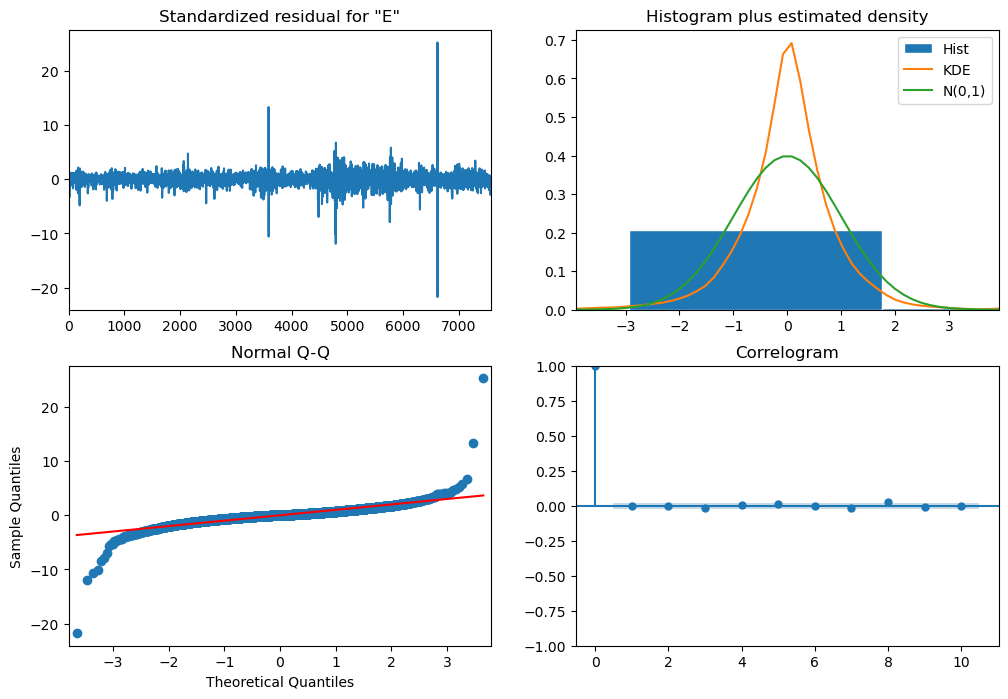

In [16]:
model_fit.plot_diagnostics(figsize=(12, 8))
plt.show()

S:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
S:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


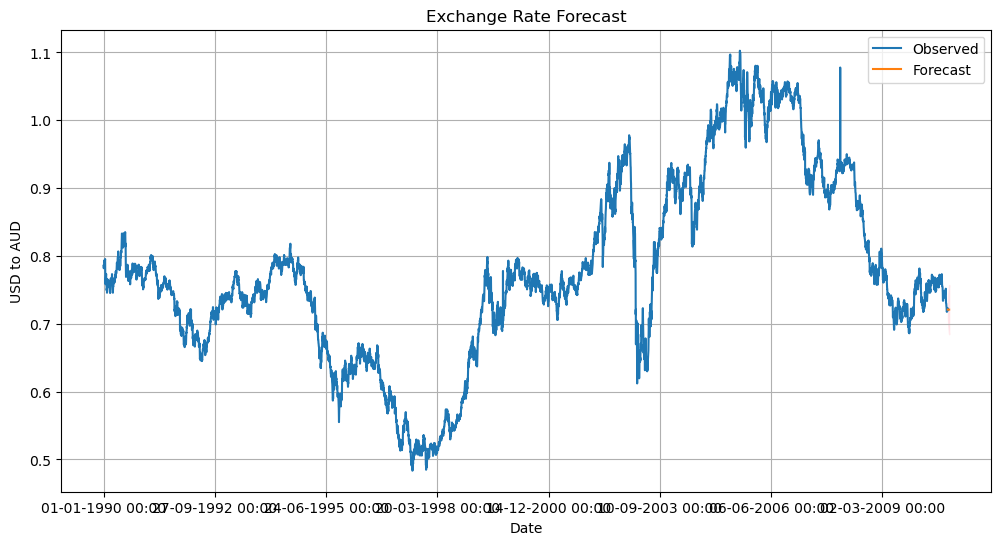

In [17]:
# Forecast next 12 periods
forecast = model_fit.get_forecast(steps=12)
forecast_ci = forecast.conf_int()

# Plot forecast
plt.figure(figsize=(12, 6))
df['Ex_rate'].plot(label='Observed')
forecast.predicted_mean.plot(label='Forecast')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Exchange Rate Forecast')
plt.xlabel('Date')
plt.ylabel('USD to AUD')
plt.legend()
plt.grid(True)
plt.show()

### Part 3: Model Building - Exponential Smoothing
#### 1.	Model Selection: Depending on the time series characteristics, choose an appropriate Exponential Smoothing model (Simple, Holt’s Linear, or Holt-Winters).
#### 2.	Parameter Optimization: Use techniques such as grid search or AIC to find the optimal parameters for the smoothing levels and components.
#### 3.	Model Fitting and Forecasting: Fit the chosen Exponential Smoothing model and forecast future values. Compare these forecasts visually with the actual data.


S:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
S:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
S:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


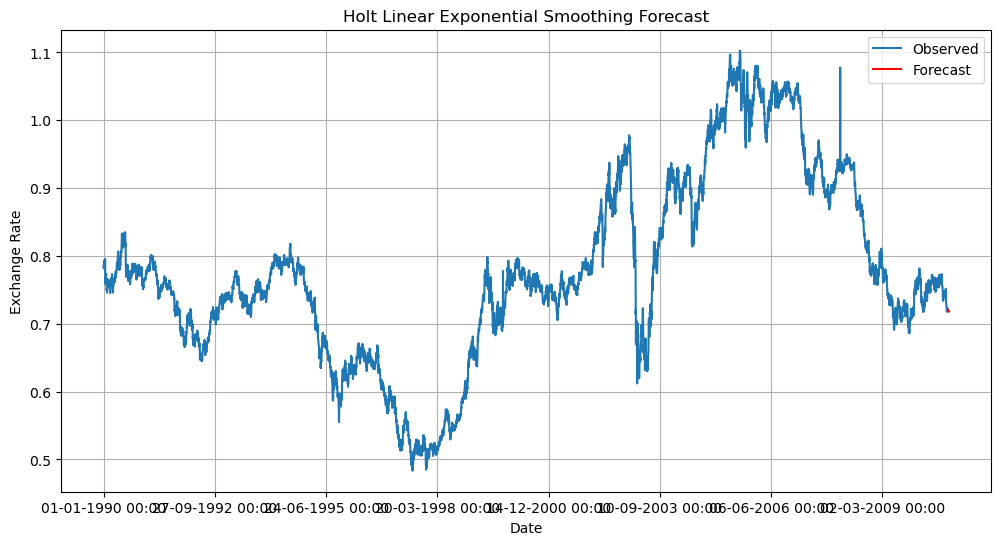

In [18]:
from statsmodels.tsa.holtwinters import Holt

# Fit Holt’s Linear Trend model
model = Holt(df['Ex_rate'])
fit = model.fit(optimized=True)

# Forecast 12 periods into the future
forecast = fit.forecast(12)

# Plot original data and forecast
plt.figure(figsize=(12, 6))
df['Ex_rate'].plot(label='Observed')
forecast.plot(label='Forecast', color='red')
plt.title('Holt Linear Exponential Smoothing Forecast')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model = ExponentialSmoothing(df['Ex_rate'], trend='add', seasonal='add', seasonal_periods=12)
fit = model.fit(optimized=True)
forecast = fit.forecast(12)

S:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
S:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
S:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


S:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
S:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
S:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


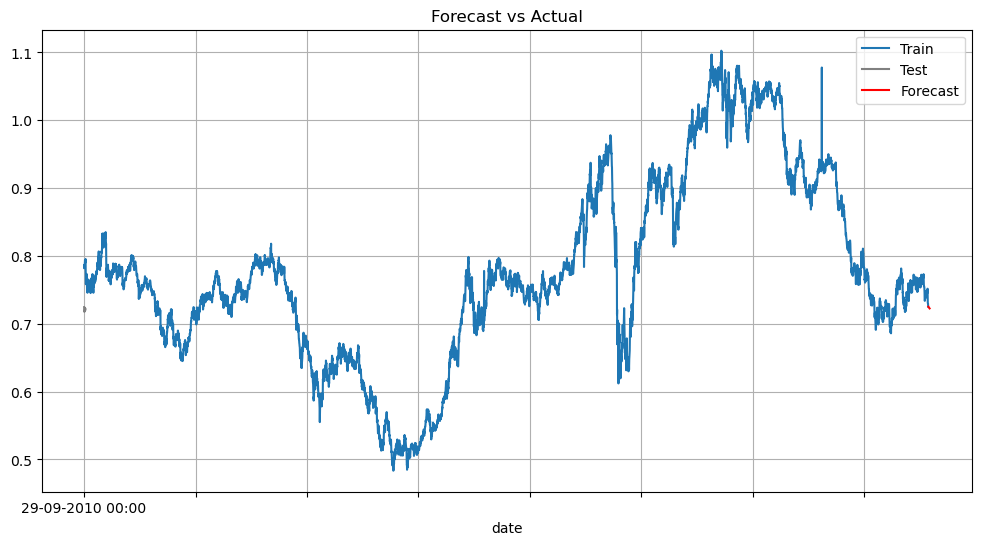

In [20]:
# Suppose you split data into training and testing
train = df.iloc[:-12]
test = df.iloc[-12:]

model = Holt(train['Ex_rate'])
fit = model.fit()
forecast = fit.forecast(12)

# Plot comparison
plt.figure(figsize=(12, 6))
train['Ex_rate'].plot(label='Train')
test['Ex_rate'].plot(label='Test', color='gray')
forecast.plot(label='Forecast', color='red')
plt.title('Forecast vs Actual')
plt.legend()
plt.grid(True)
plt.show()

### Part 4: Evaluation and Comparison
#### 1.	Compute Error Metrics: Use metrics such as MAE, RMSE, and MAPE to evaluate the forecasts from both models.
#### 2.	Model Comparison: Discuss the performance, advantages, and limitations of each model based on the observed results and error metrics.
#### 3.	Conclusion: Summarize the findings and provide insights on which model(s) yielded the best performance for forecasting exchange rates in this dataset.


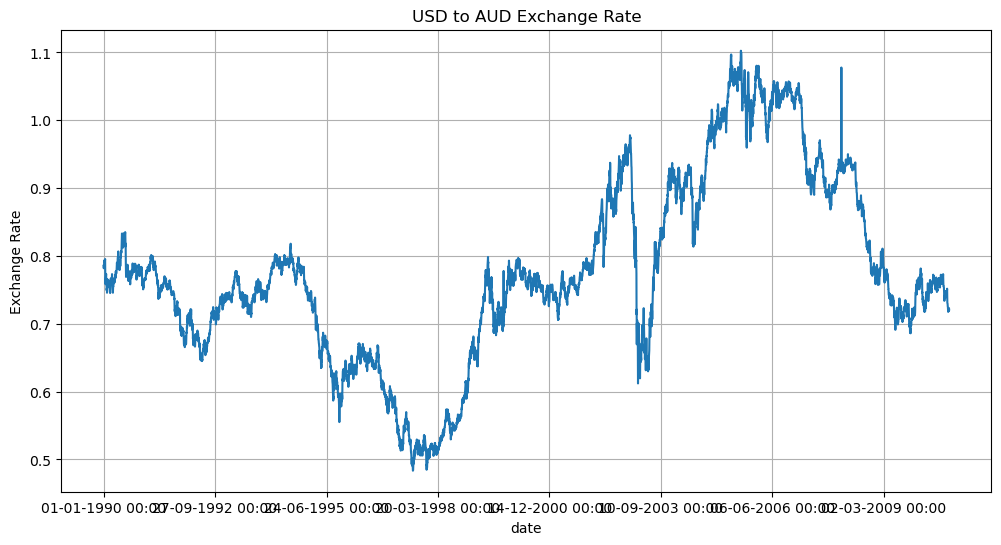

S:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
S:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
S:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
S:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
S:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will 

ARIMA - MAE: 0.0048, RMSE: 0.0052, MAPE: nan%
Holt’s - MAE: 0.0034, RMSE: 0.0040, MAPE: nan%


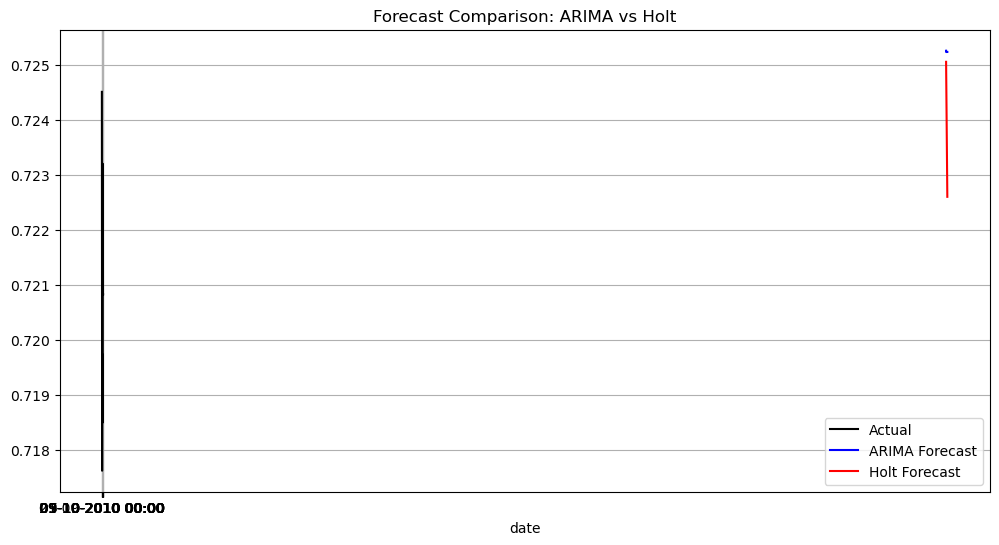

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('exchange_rate.csv', parse_dates=['date'])
df.set_index('date', inplace=True)

# Plot the time series
df['Ex_rate'].plot(figsize=(12, 6), title='USD to AUD Exchange Rate')
plt.ylabel('Exchange Rate')
plt.grid(True)
plt.show()

train = df['Ex_rate'][:-12]
test = df['Ex_rate'][-12:]

from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(train, order=(1, 1, 1))
arima_result = arima_model.fit()
arima_forecast = arima_result.forecast(steps=12)

from statsmodels.tsa.holtwinters import Holt

holt_model = Holt(train)
holt_result = holt_model.fit()
holt_forecast = holt_result.forecast(12)

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# ARIMA Errors
mae_arima = mean_absolute_error(test, arima_forecast)
rmse_arima = np.sqrt(mean_squared_error(test, arima_forecast))
mape_arima = np.mean(np.abs((test - arima_forecast) / test)) * 100

# Holt Errors
mae_holt = mean_absolute_error(test, holt_forecast)
rmse_holt = np.sqrt(mean_squared_error(test, holt_forecast))
mape_holt = np.mean(np.abs((test - holt_forecast) / test)) * 100

# Print error metrics
print(f"ARIMA - MAE: {mae_arima:.4f}, RMSE: {rmse_arima:.4f}, MAPE: {mape_arima:.2f}%")
print(f"Holt’s - MAE: {mae_holt:.4f}, RMSE: {rmse_holt:.4f}, MAPE: {mape_holt:.2f}%")

# Plot Forecasts vs Actual
plt.figure(figsize=(12, 6))
test.plot(label='Actual', color='black')
arima_forecast.plot(label='ARIMA Forecast', color='blue')
holt_forecast.plot(label='Holt Forecast', color='red')
plt.title('Forecast Comparison: ARIMA vs Holt')
plt.legend()
plt.grid(True)
plt.show()